# Titanic Data Cleaning

A look at Kaggle's Titanic dataset. In this notebook I will be cleaning both the train and test sets and using SciKit to form predictive models.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# set float values to display to 2 d.p. only
pd.options.display.float_format = "{:,.2f}".format

# load titanic data
titanic_train = pd.read_csv("./data/train.csv")
titanic_test = pd.read_csv("./data/test.csv")
gender_submission = pd.read_csv("./data/gender_submission.csv")

# append outcomes to titanic test data
train_outcomes = titanic_train["Survived"]
titanic_train = titanic_train.drop(["Survived"], axis=1)

# create full dataset and reset indices
titanic_full = titanic_train.append(titanic_test).reset_index()
titanic_full = titanic_full.drop(["index"], axis=1)
titanic_full.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


First, I want to check the whole dataset to see if there are any significant gaps. For ease of identification I am going to generate a heatmap that indicates missing data values for each column (yellow indicates missing values).

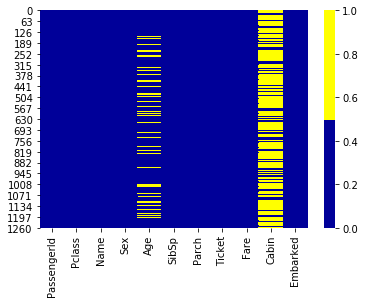

In [2]:
# Visualise missing data from each column. This is to identify columns that might be worth removing. 
colours = ['#000099', '#ffff00']
sns.heatmap(titanic_full.isnull(), cmap=sns.color_palette(colours))

The heatmap shows there is a large absence of data in the Cabin field. This is not numeric data and therefore cannot be replaced with median values, so I will drop it from the dataset. The missing Age fields can be filled out with a median average. Name, Passenger ID and Ticket fields represent no real value to the analysis, so they will also be dropped.

In [3]:
# Remove Passenger ID, Cabin, Name and Ticket columns
titanic_full_cln = titanic_full.drop(["Cabin", "Name", "Ticket", "PassengerId"], axis=1)

# Replace age NaNs with average age
titanic_full_cln['Age'] = titanic_full_cln['Age'].fillna(titanic_full_cln['Age'].median())

titanic_full_cln

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.00,1,0,7.25,S
1,1,female,38.00,1,0,71.28,C
2,3,female,26.00,0,0,7.92,S
3,1,female,35.00,1,0,53.10,S
4,3,male,35.00,0,0,8.05,S
...,...,...,...,...,...,...,...
1304,3,male,28.00,0,0,8.05,S
1305,1,female,39.00,0,0,108.90,C
1306,3,male,38.50,0,0,7.25,S
1307,3,male,28.00,0,0,8.05,S


Next, I will be checking for outliers in the continuous data columns. I can do this by creating boxplots for my continuous data fields and checking to see which values lie outside the 'minimum' and 'maximum' ranges (the black lines at the ends of each plot).

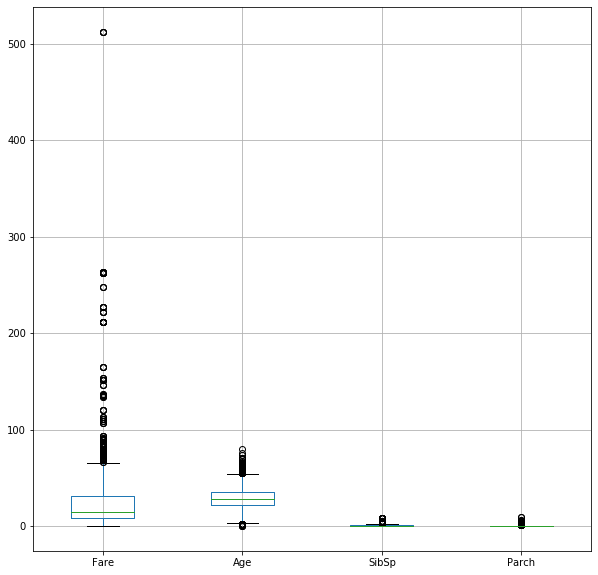

In [4]:
titanic_full_cln.boxplot(column=['Fare', 'Age', 'SibSp', 'Parch'], figsize=(10,10))

In [5]:
m_f_mapping = {'male': 1, 'female': 2}
embarked_mapping = {'S': 1, 'Q': 2, 'C': 3}

titanic_full_cln = titanic_full_cln.replace({'Sex': m_f_mapping, 'Embarked': embarked_mapping})
titanic_full_cln

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.00,1,0,7.25,1.00
1,1,2,38.00,1,0,71.28,3.00
2,3,2,26.00,0,0,7.92,1.00
3,1,2,35.00,1,0,53.10,1.00
4,3,1,35.00,0,0,8.05,1.00
...,...,...,...,...,...,...,...
1304,3,1,28.00,0,0,8.05,1.00
1305,1,2,39.00,0,0,108.90,3.00
1306,3,1,38.50,0,0,7.25,1.00
1307,3,1,28.00,0,0,8.05,1.00


Finally, I will combine the SibSp and Parch fields into a common 'Relatives' column.

In [6]:
titanic_full_cln['Relatives'] = titanic_full_cln['SibSp'] + titanic_full_cln['Parch']
titanic_full_cln = titanic_full_cln.drop(['SibSp', 'Parch'], axis=1)
titanic_full_cln

,Pclass,Sex,Age,Fare,Embarked,Relatives
0,3,1,22.00,7.25,1.00,1
1,1,2,38.00,71.28,3.00,1
2,3,2,26.00,7.92,1.00,0
3,1,2,35.00,53.10,1.00,1
4,3,1,35.00,8.05,1.00,0
...,...,...,...,...,...,...
1304,3,1,28.00,8.05,1.00,0
1305,1,2,39.00,108.90,3.00,0
1306,3,1,38.50,7.25,1.00,0
1307,3,1,28.00,8.05,1.00,0


# Creating A Model

First, I want to use a linear classifier to see the effect of siblings, spouses, parents and children on survival. 

In [7]:
# Isolate desired features in separate DataFrame
titanic_train = titanic_full_cln[:891]
titanic_test = titanic_full_cln[891:]
titanic_train

,Pclass,Sex,Age,Fare,Embarked,Relatives
0,3,1,22.00,7.25,1.00,1
1,1,2,38.00,71.28,3.00,1
2,3,2,26.00,7.92,1.00,0
3,1,2,35.00,53.10,1.00,1
4,3,1,35.00,8.05,1.00,0
...,...,...,...,...,...,...
886,2,1,27.00,13.00,1.00,0
887,1,2,19.00,30.00,1.00,0
888,3,2,28.00,23.45,1.00,3
889,1,1,26.00,30.00,3.00,0


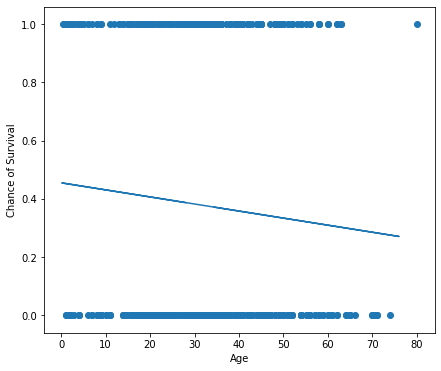

In [17]:
from sklearn import linear_model

# Generate linear model object
regr = linear_model.LinearRegression()

linear_feature = 'Age'

train_series = titanic_train[[linear_feature]]
test_series = titanic_test[[linear_feature]]

regr.fit(train_series, train_outcomes)

test_preds = regr.predict(test_series)

plt.figure(figsize=(7, 6))
ax = plt.axes()
ax.scatter(train_series, train_outcomes)
ax.plot(test_series, test_preds)

ax.set_xlabel(linear_feature)
ax.set_ylabel('Chance of Survival')

ax.axis('tight')

plt.show()